In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from base import    double_control_predict_result,\
                    gaolu_predict_raw,\
                    data_tranform_plot,\
                    get_y_aim_data,\
                    generate_yr,\
                    replace_outliers_with_weighted_diff

from base import MyRNNModel,CustomPredictor_double


In [78]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='Sheet2') 
print(df_sheet_yuansu.info())
print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

print(df_sheet_params.info())
print(df_sheet_params.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6832 entries, 0 to 6831
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳h    6832 non-null   int64  
 1   时间戳10m  6832 non-null   int64  
 2   SI      6832 non-null   float64
 3   铁口1温度   6832 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 213.6 KB
None
Index(['时间戳h', '时间戳10m', 'SI', '铁口1温度'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   主参数时间戳2  7377 non-null   int64  
 1   时间戳h     7377 non-null   int64  
 2   富氧流量     7377 non-null   float64
 3   冷风流量     7377 non-null   float64
 4   热风压力     7377 non-null   float64
 5   冷风温度     7377 non-null   float64
 6   热风温度     7377 non-null   float64
 7   鼓风湿度     7377 non-null   float64
 8   设定喷煤量    7377 non-null   float64
dtypes: float64(7), int64(2)
memor

In [79]:
import pandas as pd

# 假设 df 是你的 DataFrame

# 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_yuansu.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")


数据不包含 NaN 值


In [80]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳h'


C:\Users\haokw\AppData\Local\Temp\ipykernel_30804\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_30804\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_30804\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

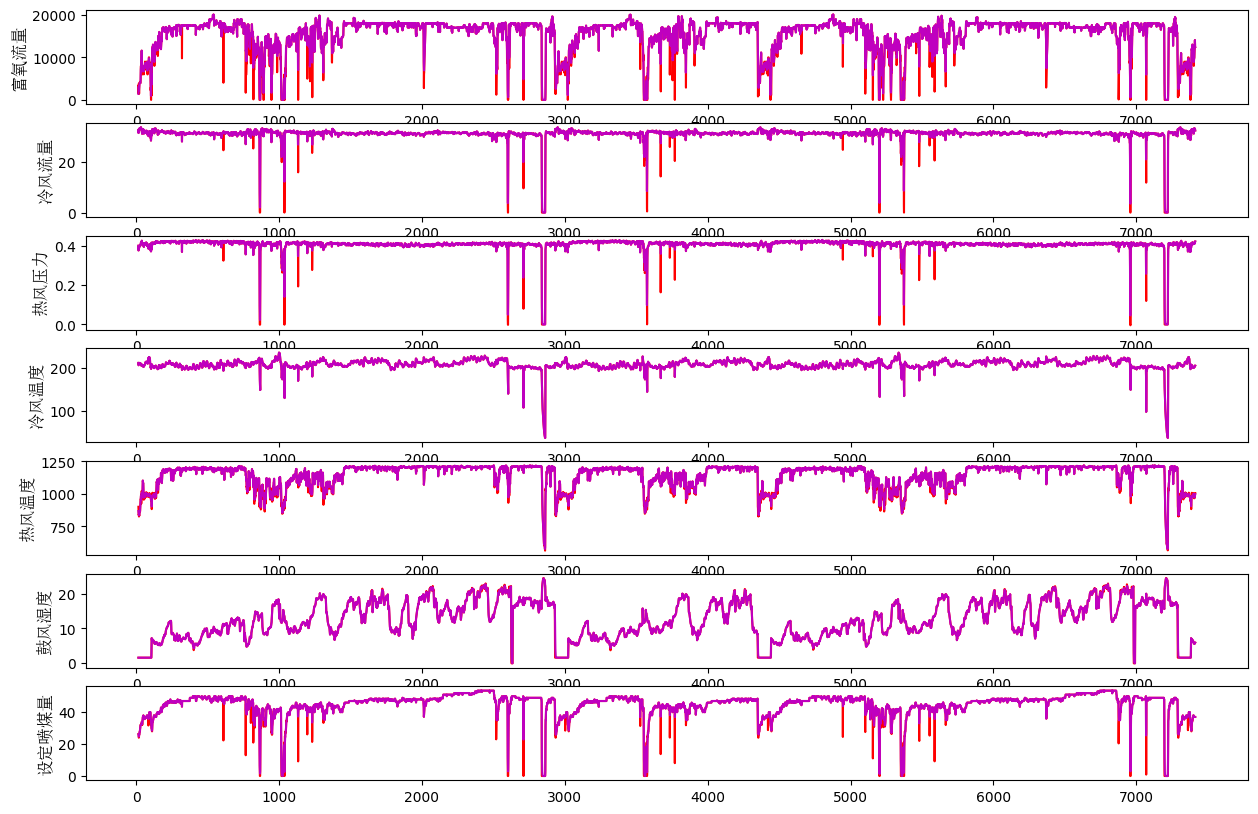

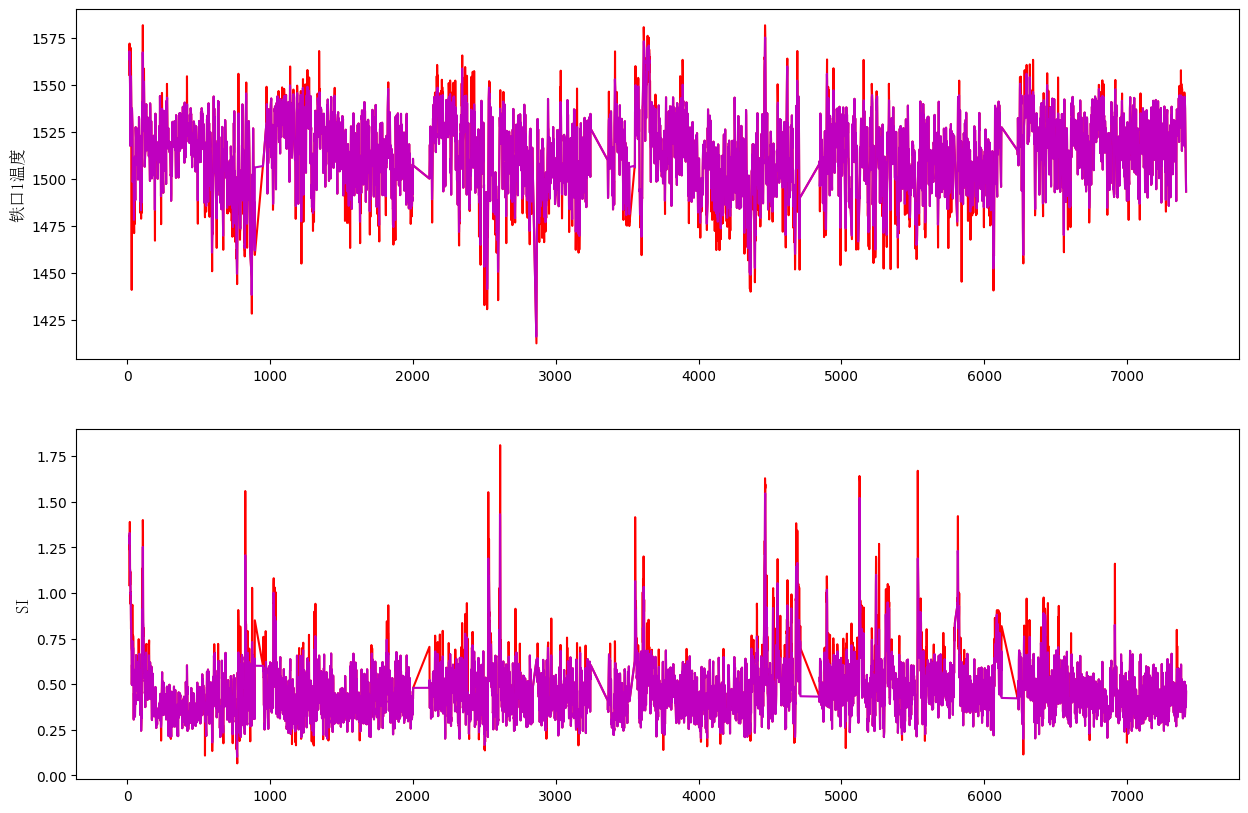

In [81]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




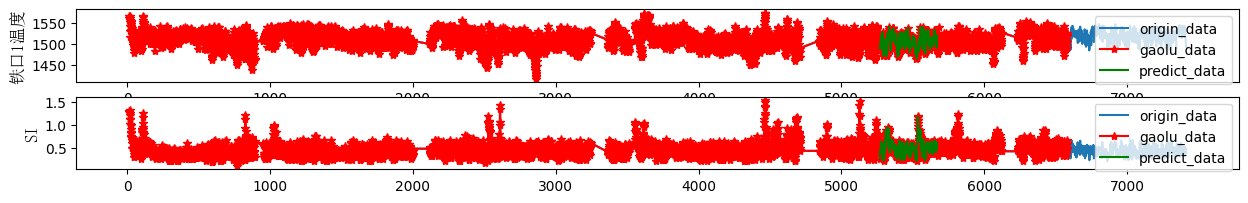

In [134]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r*-', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 6000
start1 = 0
length2 = 400
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)


In [135]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [136]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[0.05471948]
[1500.]
[0.18042565]
[1510.]
每摄氏度的输出差： [0.01257062]
[-0.44842251]
[0.5]
[-0.30986261]
[0.6]
每0.01浓度的输出差： [0.13855989]


In [154]:
# isShuffle = True
isShuffle = False


In [155]:
time_steps = 2


In [163]:
# 组合训练数据--拆分训练、测试集
test_size = 0.15
val_size = test_size
train_size = 1-val_size-test_size
# 定义时间步数和特征数

def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)



    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(3,len(y1_data)):
        print(i)
        if i in index_fanwei:
            # i = 3
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] < yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            closest_10 = closest_10.sort_values(by=time_term)
            index = closest_10.index
            # print(index)
            # print(closest_10)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps:
                print(i,yuansu_time,'errloss')
            
            else:
                X_sample = X[index, :]
                # print(X_sample)            
                # print(X_sample.shape)
                y_sample = y[i, :]  # 取每个序列的第11个时刻作为输出
                y_last = y[i-1, :].reshape(1,2)
                y_last = np.broadcast_to(y_last, (time_steps, 2))
                X_sample = np.concatenate((X_sample,y_last),axis=1)
                y_last = y[i-2, :].reshape(1,2)
                y_last = np.broadcast_to(y_last, (time_steps, 2))
                X_sample = np.concatenate((X_sample,y_last),axis=1)
                # print(X_sample)

                # print(y_sample)
                X_modified.append(X_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

        
    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [164]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



高炉模型数据
3
4 18 0 1
5 19 1 2
6 20 2 3
7 21 3 4
8 22 4 5
9 23 5 6
1024 6 7
11 25 7 8
12 26 8 9
13 27 9 10
14 28 10 11
15 29 11 12
16 30 12 13
17 31 13 14
18 32 14 15
19 33 15 16
20 34 16 17
21 35 17 18
22 36 18 19
23 37 19 20
24 38 20 21
25 39 21 22
26 40 22 23
27 41 23 24
28 42 24 25
29 43 25 26
30 44 26 27
31 45 27 28
32 46 28 29
33 47 29 30
34 48 30 31
35 49 31 32
36 50 32 33
37 51 33 34
38 52 34 35
39 53 35 36
40 54 36 37
41 55 37 38
42 56 38 39
43 57 39 40
44 58 40 41
45 59 41 42
46 60 42 43
47 61 43 44
48 62 44 45
49 63 45 46
50 64 46 47
51 65 47 48
52 66 48 49
53 67 49 50
54 68 50 51
55 69 51 52
56 70 52 53
57 71 53 54
58 72 54 55
59 73 55 56
60 74 56 57
61 75 57 58
62 76 58 59
63 77 59 60
64 78 60 61
65 79 61 62
66 80 62 63
67 81 63 64
68 82 64 65
69 83 65 66
70 84 66 67
71 85 67 68
72 86 68 69
73 87 69 70
74 88 70 71
75 89 71 72
76 90 72 73
77 91 73 74
78 92 74 75
79 93 75 76
80 94 76 77
81 95 77 78
82 96 78 79
83 97 79 80
84 98 80 81
85 99 81 82
86 100 82 83
87 101 83 84
88 102 

In [165]:
epoch_once_time = 25


In [166]:
# 建立高炉模型实例
features_size = 11
hidden_size = 16
# 设置随机种子
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 25/25 轮, 训练误差: 0.0292, 验证误差: 0.0450
epoch_sum: 25


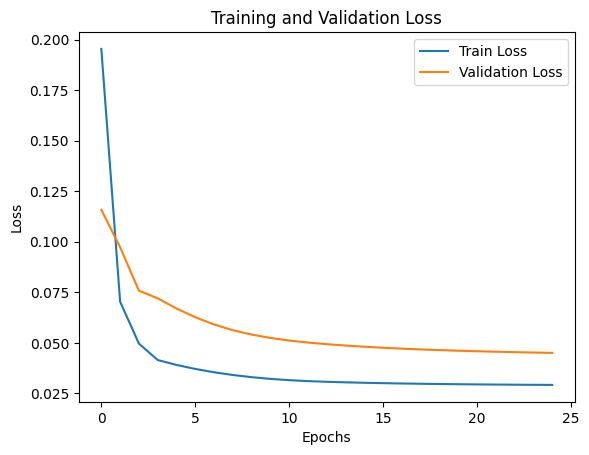

In [167]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 10.2599 , SI: 0.0977 
MAPE:  铁口1温度: 0.5274% , SI: 14.9156%
MRE :  铁口1温度: 0.0053  , SI: 0.1492 
per :  铁口1温度: 0.7094  , SI: 0.6971 


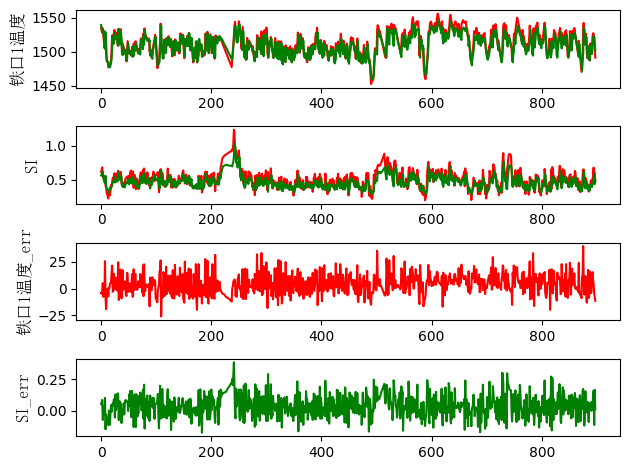

In [168]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test

# y_test = y_test[:-1]
# y_pred_0=y_pred_0[1:]
# y_pred_1=y_pred_1[1:]

double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)
